### Neural Networks (NN) for classification with PyTorch

In [ ]:
import torch  # Deep learning
import sklearn  # Machine learning
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn # All the building blocks for neural networks
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from helper_functions import plot_predictions, plot_decision_boundary

/home/hamid/miniconda3/envs/dl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hamid/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## 1. Making (Binary) classification data (custom dataset) and get it ready

* Number of features that represent a label could vary from 1 to whatever.

In [ ]:
n_samples = 1000

x, y = make_circles(n_samples,
                    noise=0.03,       # adding randomness to data (robustness)
                    random_state=42)  # flavoring randomness

type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [ ]:
len(x), len(y)  # x: (*2) features, y:labels

(1000, 1000)

In [ ]:
# Making DataFrame of circle data:
circles = pd.DataFrame({"x1":x[:,0],
                        "x2": x[:,1],
                        "label": y})

circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


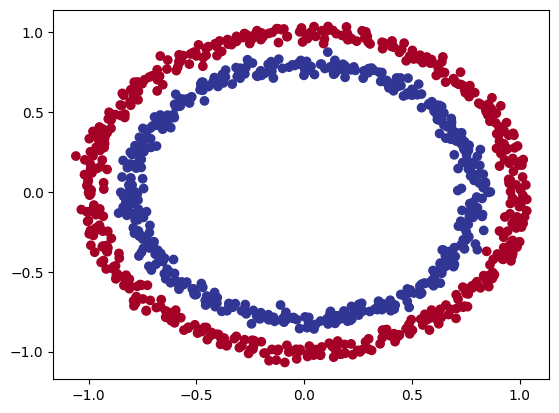

In [ ]:
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### Check input & ouput shapes (good practice)

In [ ]:
x.shape, y.shape

((1000, 2), (1000,))

### Turning data into tensors and create train and test split

In [ ]:
len(x), len(y)

(1000, 1000)

In [ ]:
x = torch.tensor(x).type(torch.float)
y = torch.tensor(y).type(torch.float)

In [ ]:
type(x), type(y)

(torch.Tensor, torch.Tensor)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,  # 20% of data for test
                                                    random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Build Model

1) Setup device-agnostic code
2) Construct the model with `nn.Module`
3) Loss function & optimizer
4) Training and test loops

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class circleClassificationModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # Takes 2 features and upscale it to 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # Takes 5 features from previous layer and outputs a single feature (same shape as y)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> y
    
model_0 = circleClassificationModel().to(device)
model_0

circleClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Replicating the above model in a more compact way:
model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

### Making some predictions with model

In [ ]:
model_0_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1534, -0.0022],
                      [ 0.6322, -0.4333],
                      [-0.4162,  0.2973],
                      [-0.3986, -0.5347],
                      [ 0.6200,  0.5320]])),
             ('0.bias', tensor([-0.4571,  0.0298, -0.6129,  0.0301,  0.4754])),
             ('1.weight',
              tensor([[-0.2655, -0.4377, -0.2312,  0.2519, -0.3523]])),
             ('1.bias', tensor([-0.2490]))])

In [ ]:
with torch.inference_mode():
    untrained_preds = model_0_seq(x_test.to(device))

# Expect to be random values since no training is happened so far:
print(len(untrained_preds), untrained_preds.shape)
print(len(x_test), x_test.shape)
print(untrained_preds[:10])
print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200, 2])
tensor([[-0.1237],
        [-0.3585],
        [ 0.2266],
        [-0.2219],
        [-0.1942],
        [-0.3342],
        [-0.6618],
        [-0.6572],
        [ 0.2438],
        [-0.3789]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup loss function and optimizer:

Which loss function and optimizer should we use? It is problem-specific, so just <u>google it up</u>.

e.g. for regression two of the most common **loss functions** are MAE and MSE. For classificatioin you might want cross entropy or categorical cross entropy

And for **optimizers**, two of the most common and useful are `SGD` and `Adam`.

Some common choices for loss function: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

and for optimizer: https://docs.pytorch.org/docs/stable/optim.html#algorithms

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  # Numerically more stable than BCE with sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0_seq.parameters(),
                            lr=0.1)

In [ ]:
# Defining accuracy function - What percentage does our model get right?
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100
    return acc

# 3. Training loop

1) Forward pass (Forwardpropagation)
2) Loss
3) Optimizer (zero grad)
4) Loss backward (backpropagation)
5) Optimizer step (grad descent)

Going from raw logits -> prediction probabilities -> prediction labels

The model outputs are going to be raw **logits** (raw, pre-sigmoid/softmax scores $y$ output by a model e.g., $y = W^⊤x+b$).

We can convert these logits into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
model_0_seq.eval()
with torch.inference_mode():
    y_logits = model_0_seq(x_test.to(device))[:5]

y_logits

tensor([[-0.1237],
        [-0.3585],
        [ 0.2266],
        [-0.2219],
        [-0.1942]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Using sigmoid activation function on our model logits to turn them into prediction probabilities:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4691],
        [0.4113],
        [0.5564],
        [0.4447],
        [0.4516]])

In [ ]:
# Finding the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0_seq(x_test.to(device))[:5]))

# Check for equality:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Getting rid of extra dim:
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 0.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_seq = model_0_seq.to(device)

epochs = 100

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# len(x_train), len(y_train), type(x_train), type(y_train)

### Training loop:
# for epoch in range(epochs):
for epoch in tqdm(range(epochs), desc="Epochs"):

    model_0_seq.train()

    # 1. Forwardpropagation:
    y_logits = model_0_seq(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # raw logits -> prediction probabilities -> prediction labels

    # 2. loss / accuracy:
    loss = loss_fn(y_logits, 
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_pred)
    
    # 3. Optimizer (zero grad):
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation):
    loss.backward()

    # 5. Optimizer step (gradient descent):
    optimizer.step()

    ### Testing loop:
    model_0_seq.eval()
    with torch.inference_mode():
        # 1. Forwardpropagation:
        test_logits = model_0_seq(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Loss / accuracy:
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_pred)
    
    # if epoch % 10 == 0: 
    #     print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.3f}" )


Epochs: 100%|██████████| 100/100 [00:00<00:00, 1488.22it/s]


# 4. Evaluating the model:

### Visualize, visualize, visualize!

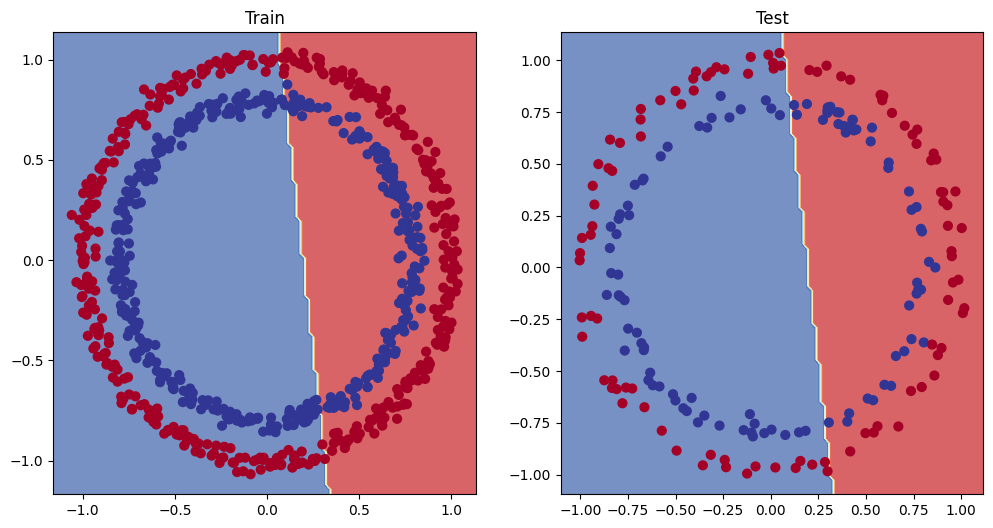

In [ ]:
# Plot decision boundary of the model:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0_seq, x_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0_seq, x_test, y_test)

# 5. Improving the model (model-centric)

* **Adding more layers**: gives the model chances to learn about patterns in the data.
* **Adding more hidden units**: # neurons in each hidden layers, basically the more parameters our model has to represent the data, it can potentially learn better.
* **Fit for longer**: more epochs
* **Changing the activation function**
* **Changing the learning rate**
* **Changing the loss function**
* **Changing the optimization function**

The above are usually called as `Hyperparameters` since we as data scientists have control on.

In [ ]:
## Changing the model architecture:
class circleClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

improved_model = circleClassificationModelV1().to(device)
improved_model

circleClassificationModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=improved_model.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

improved_model = improved_model.to(device)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

### Training loop:
# for epoch in range(epochs):
for epoch in tqdm(range(epochs), desc="Epochs"):

    improved_model.train()

    # 1. Forwardpropagation:
    y_logits = improved_model(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # raw logits -> prediction probabilities -> prediction labels

    # 2. loss / accuracy:
    loss = loss_fn(y_logits, 
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_pred)
    
    # 3. Optimizer (zero grad):
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation):
    loss.backward()

    # 5. Optimizer step (gradient descent):
    optimizer.step()

    ### Testing loop:
    improved_model.eval()
    with torch.inference_mode():
        # 1. Forwardpropagation:
        test_logits = improved_model(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Loss / accuracy:
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_pred)

Epochs: 100%|██████████| 1000/1000 [00:02<00:00, 485.49it/s]


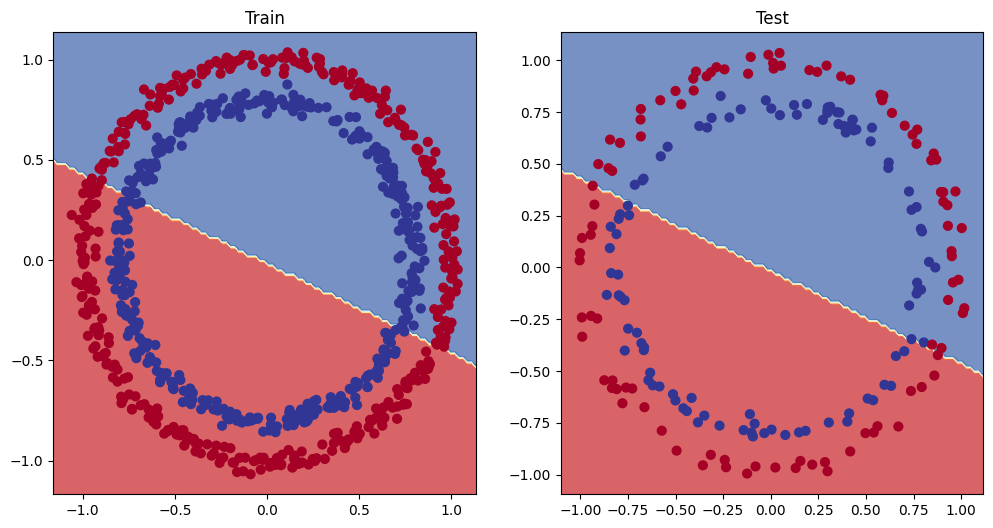

In [ ]:
# Plot decision boundary of the model:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(improved_model, x_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(improved_model, x_test, y_test)

### Testing the model on a simpler dataset to evaluate its functionality

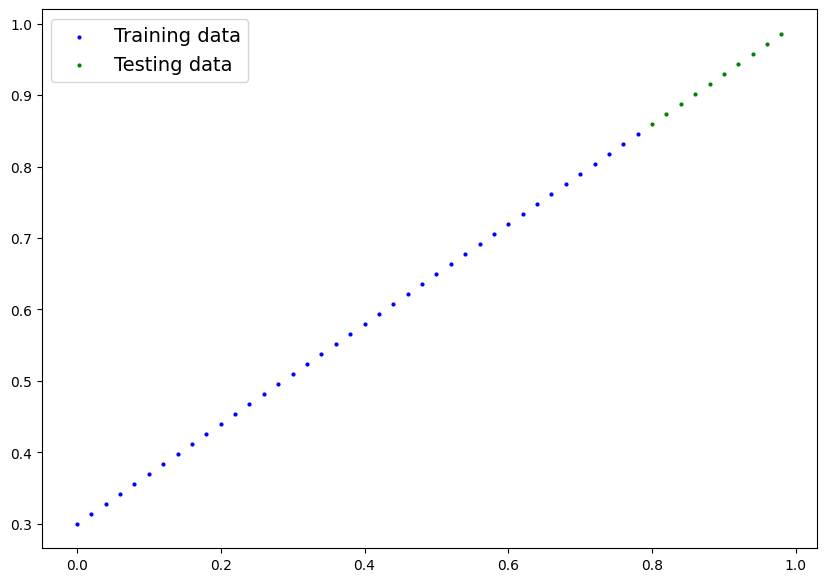

In [ ]:
weight = 0.7
bias = 0.3
init_pt = 0.
final_pt = 1.
sample_size = 0.02

simple_x = torch.arange(init_pt, final_pt, sample_size)
simple_label = weight * simple_x + bias

simple_x.shape, simple_label.shape

# Split data:
train_set = int(.8 * len(simple_x))
x_train_regression, y_train_regression = simple_x[:train_set].unsqueeze(1), simple_label[:train_set].unsqueeze(1)
x_test_regression, y_test_regression = simple_x[train_set:].unsqueeze(1), simple_label[train_set:].unsqueeze(1)

x_train_regression.shape, y_train_regression.shape, x_test_regression.shape, y_test_regression.shape

plot_predictions(train_data=x_train_regression,
                 train_labels=y_train_regression,
                 test_data=x_test_regression,
                 test_labels=y_test_regression)


In [ ]:
improved_model_regression = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

improved_model_regression

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=improved_model_regression.parameters(),
                            lr=0.1)

In [ ]:
### Train and test:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

improved_model_regression = improved_model_regression.to(device)

epochs = 100

# Putting the data on target device (GPU):
x_train_regression, label_train_regression = x_train_regression.to(device), y_train_regression.to(device)
x_test_regression, label_test_regression = x_test_regression.to(device), y_test_regression.to(device)


for epoch in tqdm(range(epochs), desc="Epochs"):

    improved_model_regression.train()  # training mode
    y_preds = improved_model_regression(x_train_regression)  # forwardpropagation
    loss = loss_fn(y_preds, label_train_regression)  # forward loss
    optimizer.zero_grad()
    loss.backward()  # backpropagation
    optimizer.step()  # gradient descent


    improved_model_regression.eval()  # evaluation mode
    with torch.inference_mode():  # Make predictions
        test_preds = improved_model_regression(x_test_regression)
        test_loss = loss_fn(test_preds, label_test_regression)


Epochs: 100%|██████████| 100/100 [00:00<00:00, 4183.68it/s]


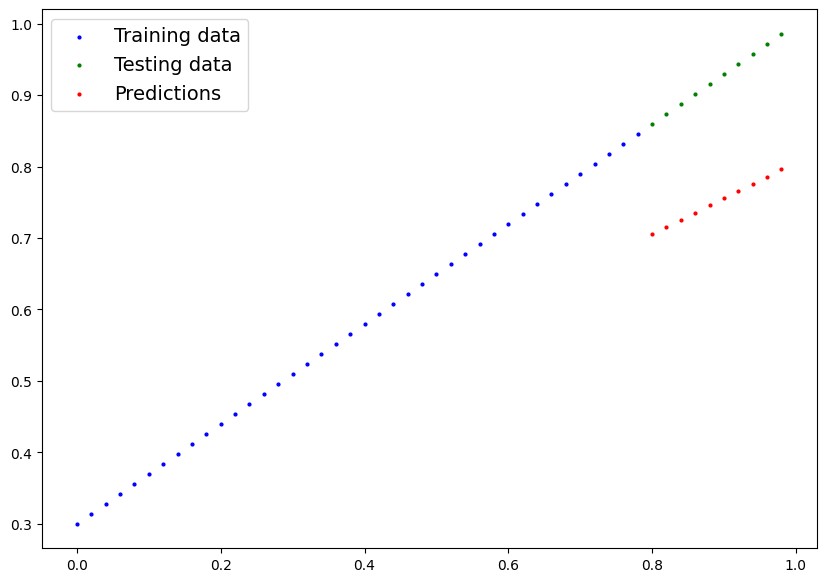

In [ ]:
improved_model_regression.eval()
with torch.inference_mode():
    test_preds = improved_model_regression(x_test_regression)

plot_predictions(train_data=x_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=x_test_regression.cpu(),
                 test_labels=label_test_regression.cpu(),
                 predictions=test_preds.cpu())

## Adding **nonlinearity** to the model

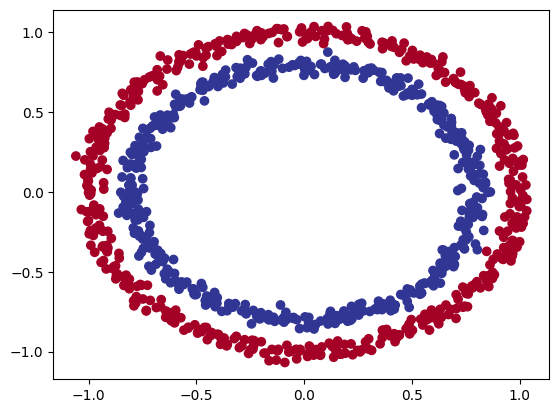

In [ ]:
n_samples = 1000

x, y = make_circles(n_samples,
                    noise=0.03,       # adding randomness to data (robustness)
                    random_state=42)  # flavoring randomness

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,  # 20% of data for test
                                                    random_state=42)

# x_train.shape, x_test.shape, y_train.shape, y_test.shape
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [ ]:
class nonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.lin_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.lin_layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu_layer  = nn.ReLU()

    def forward(self, x):
        return self.lin_layer_3(self.relu_layer(self.lin_layer_2(self.relu_layer(self.lin_layer_1(x)))))

nonLinearModelIns = nonLinearModel().to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(nonLinearModelIns.parameters(),
                               lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

nonLinearModelIns = nonLinearModelIns.to(device)

epochs = 1000

# Putting the data on target device (GPU):
x_train, y_train = x_train.to(device).squeeze(), y_train.to(device).squeeze()
x_test, y_test = x_test.to(device).squeeze(), y_test.to(device).squeeze()

for epoch in tqdm(range(epochs), desc="Epochs"):

    nonLinearModelIns.train()  # training mode
    y_logits = nonLinearModelIns(x_train).squeeze()  # forwardpropagation
    y_preds = torch.round(torch.sigmoid(y_logits))  # logits -> pred probs -> pred labels
    loss = loss_fn(y_logits, y_train)  # forward loss
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_preds)
    optimizer.zero_grad()
    loss.backward()  # backpropagation
    optimizer.step()  # gradient descent

    nonLinearModelIns.eval()  # evaluation mode
    with torch.inference_mode():  # Make predictions
        test_logits = nonLinearModelIns(x_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_preds)


Epochs: 100%|██████████| 10000/10000 [00:23<00:00, 417.43it/s]


In [ ]:
nonLinearModelIns.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(nonLinearModelIns(x_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

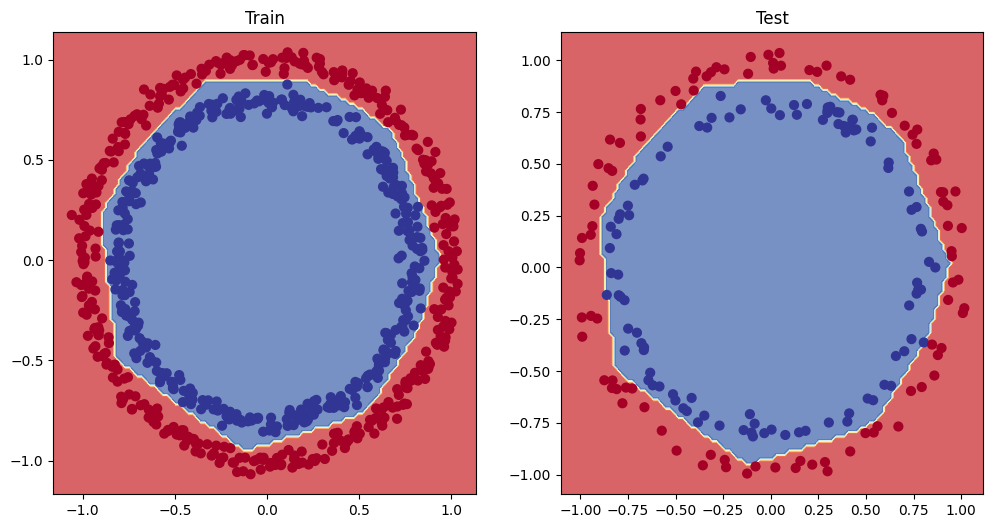

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(nonLinearModelIns, x_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(nonLinearModelIns, x_test, y_test)


## Replicating nonlinear acativation function